# Let's start with langgraph

In [ ]:
from langgraph.graph import StateGraph, START, END

# Let's define a node

In [ ]:
def node_1(state):
    # procesamiento ...
    return {"message": "bye!", "longitud": len(state["message"])}

# Let's define a State

In [ ]:
from typing_extensions import TypedDict

class MyState(TypedDict):
    message: str
    longitud: int

In [ ]:
MyState(message="hola", longitud=10)

# Let's build our Graph

In [ ]:
graph_builder = StateGraph(MyState)

graph_builder.add_node("node 1", node_1)

graph_builder.add_edge(START, "node 1")
graph_builder.add_edge("node 1", END)

graph = graph_builder.compile()

In [ ]:
graph

In [ ]:
graph.invoke({"message": "holaassdfdsa!", "longitud": 100})

# Let's define a reducer

In [ ]:
from langgraph.graph import StateGraph, START, END
import operator
from typing import Annotated
from typing_extensions import TypedDict

class MyState(TypedDict):
    message: Annotated[str, operator.add]

def node_1(state):
    return {"message": " james!"}

def node_2(state):
    return {"message": " how are you?"}

In [ ]:
graph_builder = StateGraph(MyState)

graph_builder.add_node("node_1", node_1)
graph_builder.add_node("node_2", node_2)

graph_builder.add_edge(START, "node_1")
graph_builder.add_edge("node_1", "node_2")
graph_builder.add_edge("node_2", END)

graph = graph_builder.compile()

In [ ]:
graph.invoke({"message": "hey"})

# Let's add a conditional edge

In [ ]:
from langgraph.graph import StateGraph, START, END
import operator
from typing import Annotated
from typing_extensions import TypedDict

class MyState(TypedDict):
    message: Annotated[str, operator.add]

def node_1(state):
    return {"message": " james!"}

def node_2(state):
    return {"message": " how are you?"}

def node_3(state):
    return {"message": " it's all ok?"}

In [ ]:
from random import random
from typing import Literal

def take_a_path(state) -> Literal["node_2", "node_3"]:
    if random() < 0.5:
        return "node_2"
    
    return "node_3"


graph_builder = StateGraph(MyState)

graph_builder.add_node("node_1", node_1)
graph_builder.add_node("node_2", node_2)
graph_builder.add_node("node_3", node_3)

graph_builder.add_edge(START, "node_1")
graph_builder.add_conditional_edges("node_1", take_a_path)
graph_builder.add_edge("node_2", END)
graph_builder.add_edge("node_3", END)


graph = graph_builder.compile()

In [ ]:
graph

In [ ]:
graph.invoke({"message": "hi"})

# Let's build a basic chatbot - START HERE

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
)

In [5]:
from langchain_core.messages import HumanMessage, AIMessage
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END


class ChatbotState(TypedDict):
    user_request: str
    answer: str

def chatbot(state):
    user_request = state["user_request"]
    ai_answer: AIMessage = llm.invoke([HumanMessage(content=user_request)])

    return {"answer": ai_answer.content}


graph_builder = StateGraph(ChatbotState)

graph_builder.add_node("chatbot", chatbot)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

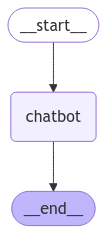

In [6]:
graph

In [7]:
graph.invoke({"user_request": "hi!"})

{'user_request': 'hi!', 'answer': 'Hello! How can I assist you today?'}

# Let's use a better state

In [9]:
from langgraph.graph.message import add_messages, MessagesState
from typing import Annotated

class State(TypedDict):
    messages: Annotated[list, add_messages]

def chatbot(state):
    ai_answer = llm.invoke(state["messages"])

    return {"messages": [ai_answer]}


graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

In [10]:
graph.invoke({"messages": [("user", "hi!")]})

{'messages': [HumanMessage(content='hi!', additional_kwargs={}, response_metadata={}, id='95398441-9751-48e7-b900-61f0fab540aa'),
  AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 9, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'stop', 'logprobs': None}, id='run-784667f7-ccae-495a-a927-15a4b2544dab-0', usage_metadata={'input_tokens': 9, 'output_tokens': 10, 'total_tokens': 19, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

# Let's add memory

In [11]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()


In [12]:
graph = graph_builder.compile(checkpointer=memory)

In [13]:
graph.invoke({"messages": [("user", "hi!")]}, config={"configurable": {"thread_id": "id1"}})

{'messages': [HumanMessage(content='hi!', additional_kwargs={}, response_metadata={}, id='af3538f7-e860-421b-9953-829cca6663a7'),
  AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 9, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_523b9b6e5f', 'finish_reason': 'stop', 'logprobs': None}, id='run-21053a74-27ef-46dc-8e19-b02071d3b962-0', usage_metadata={'input_tokens': 9, 'output_tokens': 10, 'total_tokens': 19, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [14]:
graph.invoke({"messages": [("user", "my name is james")]}, config={"configurable": {"thread_id": "id1"}})

{'messages': [HumanMessage(content='hi!', additional_kwargs={}, response_metadata={}, id='af3538f7-e860-421b-9953-829cca6663a7'),
  AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 9, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_523b9b6e5f', 'finish_reason': 'stop', 'logprobs': None}, id='run-21053a74-27ef-46dc-8e19-b02071d3b962-0', usage_metadata={'input_tokens': 9, 'output_tokens': 10, 'total_tokens': 19, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(content='my name is james', additional_kwargs={}, response_metadata={}, id='401add01-f134-426f-b022-7

In [15]:
graph.invoke({"messages": [("user", "who am i?")]}, config={"configurable": {"thread_id": "id1"}})

{'messages': [HumanMessage(content='hi!', additional_kwargs={}, response_metadata={}, id='af3538f7-e860-421b-9953-829cca6663a7'),
  AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 9, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_523b9b6e5f', 'finish_reason': 'stop', 'logprobs': None}, id='run-21053a74-27ef-46dc-8e19-b02071d3b962-0', usage_metadata={'input_tokens': 9, 'output_tokens': 10, 'total_tokens': 19, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(content='my name is james', additional_kwargs={}, response_metadata={}, id='401add01-f134-426f-b022-7